In [1]:
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchgeo.datasets import RasterDataset, stack_samples, unbind_samples
from torchgeo.datasets.utils import BoundingBox
from torchgeo.samplers import RandomGeoSampler, PreChippedGeoSampler, GridGeoSampler
from torchvision.utils import save_image
from torchvision import transforms, utils
from torchvision.io import read_image
from torchvision.models.vgg import vgg19

import rasterio

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from tqdm import tqdm

from PIL import Image

In [2]:
def set_seed(SEED = 456):
    np.random.seed(SEED)
    torch.manual_seed(SEED)
    torch.cuda.manual_seed(SEED)
    torch.backends.cudnn.deterministic = True

set_seed()

In [3]:
# Clase que lee imagenes .tif que hereda de `RasterDataset`, clase de torchgeo
class Sentinel2(RasterDataset):
    filename_glob = "RT_*T144923.tif"
    date_format = "%Y%m%dT%H%M%S"
    is_image = True
    separate_files = True
    all_bands = ["B02", "B03", "B04", "B08"]
    rgb_bands = ["B04", "B03", "B02"]
    
    def plot(self, sample, title=""):
        # Find the correct band index order
        rgb_indices = []
        for band in self.rgb_bands:
            rgb_indices.append(self.all_bands.index(band))

        # Reorder and rescale the image
        image = sample["image"][rgb_indices].permute(1, 2, 0)

        fig, ax = plt.subplots(figsize=(4,4))
        ax.set_title(title)
        ax.imshow(image)

        return fig
    
    def save(self, sample, name=""):
        rgb_indices = []
        for band in self.rgb_bands:
            rgb_indices.append(self.all_bands.index(band))
        
        image = sample["image"][rgb_indices] #.permute(0, 1, 2)    
        save_image(image, path + '../images_png/' + name + ".png")

### Dataloader

In [4]:
class GlacierRock(DataLoader):
    """ GlacierRock dataset."""

    def __init__(self, path: str, transform = None) -> None:
        """
        Args:
            path (str): Ruta donde se ubican las imagenes.
        """
        super(GlacierRock).__init__()
        self.path = path
        self.transforms = transform
        self.samples = []
        
        image_list = list(os.listdir(self.path))
        
        for image in image_list:
            self.samples.append((os.path.abspath(path + '/' + image), self.label_normalize(image)))

    def __len__(self):
        return len(self.samples)

    def label_normalize(self, label):
        if label.split("_")[0] == "glaciarRoca":
            return torch.tensor([1,0]).float()
        else:
            return torch.tensor([0,1]).float()
        

    def __getitem__(self, idx):
        image = read_image(self.samples[idx][0])
        label = self.samples[idx][1]

        if self.transforms:
            image = self.transforms(image)
        
        return image, label

### Pre-entrenando el modelo VGG19

In [5]:
class TrainingVGG19(object):
    def __init__(self, device=None, freeze=False):
        self.device = ("cuda:0" if torch.cuda.is_available() else "cpu") if device is None else device
        self.model = vgg19(weights='DEFAULT')
        
        if freeze:
            for param in self.model.parameters():
                  param.requires_grad = False
        
        self.model.classifier[6] = nn.Linear(self.model.classifier[6].in_features, 2) 
        self.model = self.model.to(self.device)
        self.criterion = nn.CrossEntropyLoss()
        self.train_logs = [] 
        self.val_logs = []
        self.acc_train_logs = []
        self.acc_val_logs = []
        self.acc = 0
    
    def fit(self, train_loader, test_loader, learning_rate=0.0001, epochs=15):
        
        self.train_logs, self.val_logs, self.acc_train_logs, self.acc_val_logs = [], [], [], []
        optimizer = torch.optim.Adam(self.model.parameters(), lr=learning_rate)
        
        best_acc = 0
        bar = tqdm(range(epochs), mininterval=1)
        step = 0
        
        for epoch in bar:
            self.model.train()
            train_total_loss, val_total_loss = [], []
            for inputs, labels in train_loader:
                inputs, labels =  inputs.to(self.device), labels.to(self.device)
                # Gradientes en cero
                optimizer.zero_grad()
                # Forward
                outputs = self.model(inputs)
                # Loss
                loss =  self.criterion(outputs, labels)
                # Backpropagation
                loss.backward()
                # Actualizacion de parametros
                optimizer.step()
                
                train_total_loss.append(loss.item())
                step += 1

            train_avg_loss = sum(train_total_loss) / len(train_total_loss)
            self.train_logs.append(train_avg_loss)
        
            self.model.eval()
            correct = 0
            with torch.no_grad():
                torch.cuda.empty_cache()
                for inputs, labels in test_loader:
                    inputs, labels =  inputs.to(self.device), labels.to(self.device)
                    
                    outputs = self.model(inputs)
                    
                    _, preds = torch.max(outputs, 1, keepdim=False)
                    _, label = torch.max(labels, 1, keepdim=False)
                    
                    correct = (preds == label).sum()
                    self.acc = correct.float()/label.shape[0]
                    
                    loss_eval = self.criterion(outputs, labels)
                    val_total_loss.append(loss_eval.item())
                
                if self.acc > best_acc:
                    best_acc = self.acc
                    torch.save(self.model.state_dict(), 'rock_glacier_model_v1.pt')
            
            val_avg_loss = sum(val_total_loss) / len(val_total_loss)
            self.val_logs.append(val_avg_loss)
            self.acc_val_logs.append(self.acc.cpu())
            bar.set_description(f'Epoch: {epoch}, Train Loss: {train_avg_loss:.4f}, Eval Loss: {val_avg_loss:.4f}, Acc: {self.acc}')
            step = 0
            

    def plot(self, title="Titulo", savefig=False):
        fig, axes = plt.subplots(1, 2, figsize=(18, 6.5))
        ax1, ax2 = axes
        ax1.plot(range(len(self.train_logs)), self.train_logs, label="Training Loss")
        ax1.plot(range(len(self.val_logs)), self.val_logs, label="Validation Loss")
        ax1.set_title("Loss " + title)
        ax1.set_xlabel('epochs')
        ax1.set_ylabel('Loss')
        ax1.legend()
        ax2.plot(range(len(self.val_logs)), self.acc_val_logs, label="Validation Accuracy")
        ax2.set_title("Precisión " + title)
        ax2.set_xlabel('epochs')
        ax2.set_ylabel('Accuracy')
        ax2.legend()
        if savefig:
            plt.savefig("./{}-{}-{}-{}.png".format(title, type(self.model).__name__, self.acc, len(self.train_logs)), dpi=200)
        plt.show()

In [6]:
path = "../data/"

In [7]:
transform = transforms.Compose([
                transforms.Resize(256),
                transforms.CenterCrop(224),
                transforms.ToPILImage(),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            ])

train = GlacierRock(path + 'train', transform)
train_dataset = DataLoader(train, batch_size=64, shuffle=True)

test = GlacierRock(path + 'test', transform)
test_dataset = DataLoader(test, batch_size=64, shuffle=True)

In [8]:
epochs = 50
learning_rate = 0.0001
device = 'cuda:0'

In [9]:
rg_model = TrainingVGG19(freeze=True)

In [10]:
rg_model.fit(train_dataset, test_dataset, learning_rate=learning_rate, epochs=epochs)

Epoch: 49, Train Loss: 0.2971, Eval Loss: 0.2992, Acc: 0.9655172228813171: 100%|


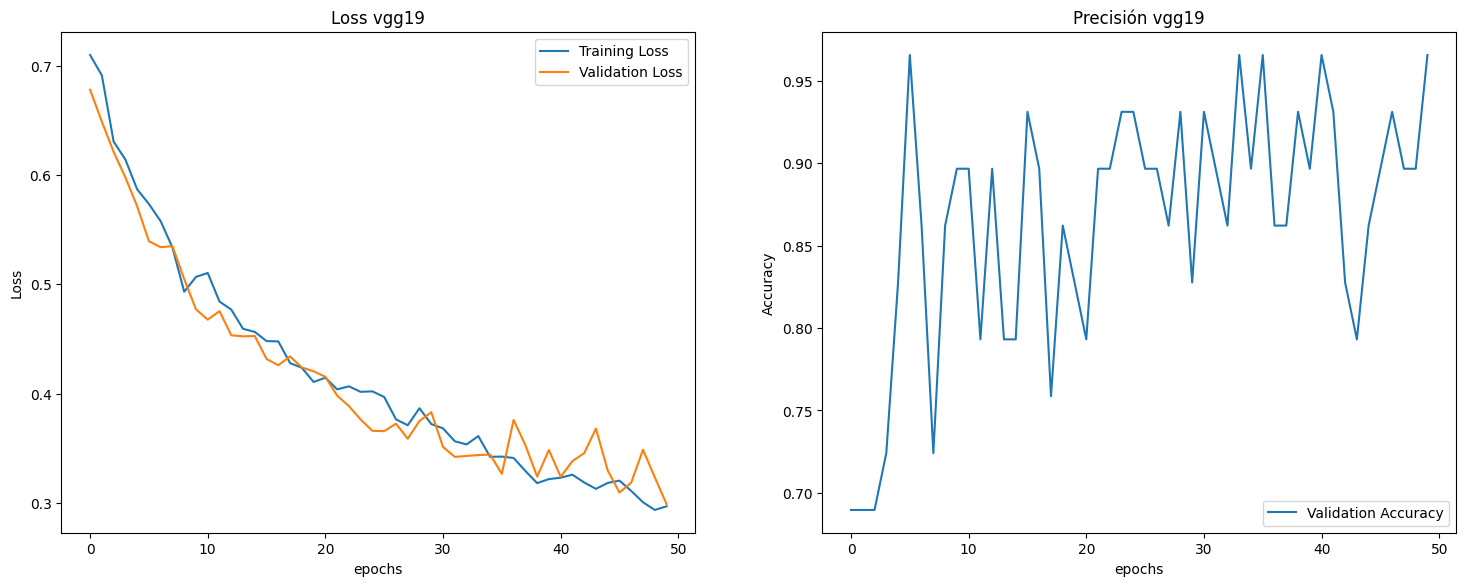

In [11]:
rg_model.plot("vgg19")

### Testeando el modelo

In [12]:
# Se está testeando con una imagen .tif del dataset
# https://drive.google.com/file/d/14ZV8BXU8JZYYTb6ifq54q84MaIhL1H3s/view?usp=sharing
path = '../dataset/polygon_images/'

Se carga el modelo con mejor acc.

In [13]:
model = vgg19(weights='DEFAULT')
model.classifier[6] = nn.Linear(model.classifier[6].in_features, 2)
model.load_state_dict(torch.load(os.getcwd() + '/rock_glacier_model_v1.pt'))
model.eval().to('cuda:0')

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

Poligonos de los glaciares con CRS = EPSG:32719
- BoundingBox(429245, 430308, 6852724, 6855871, 0, 9.223372036854776e+18) # Glaciar roca - Maranceles
- BoundingBox(437852, 439912, 6869221, 6870928, 0, 9.223372036854776e+18) # Glaciar roca - Los Helados
- BoundingBox(429105, 435519, 6864773, 6869863, 0, 9.223372036854776e+18) # Cordillera

/tmp/ipykernel_134846/3229291610.py:19: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(figsize=(4,4))


31 43


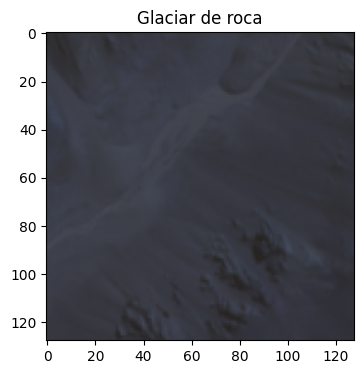

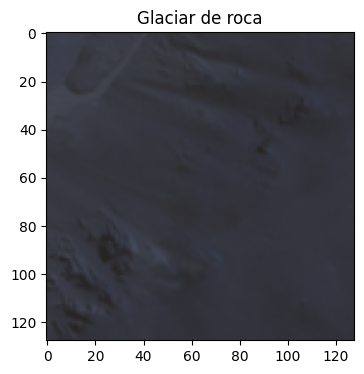

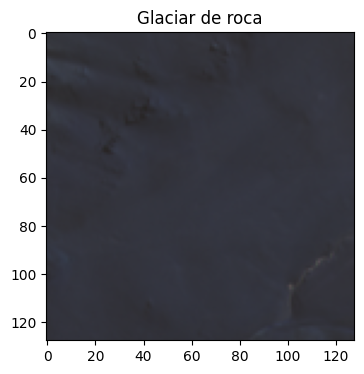

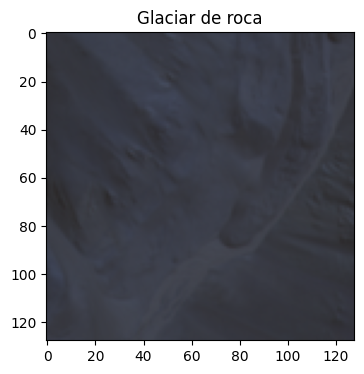

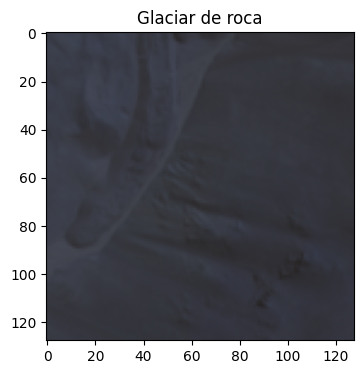

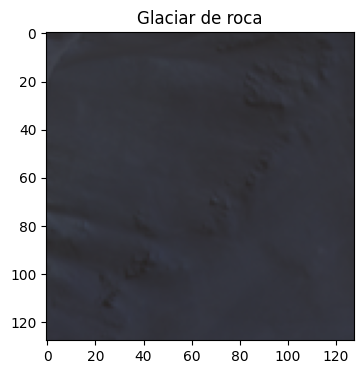

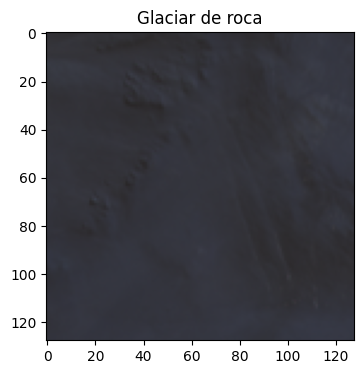

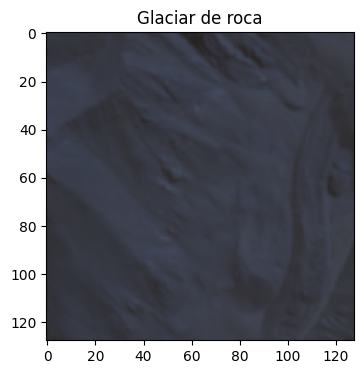

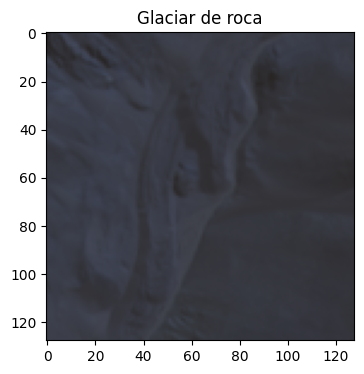

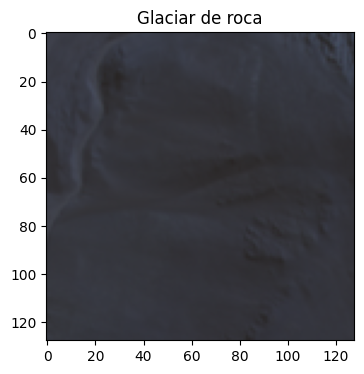

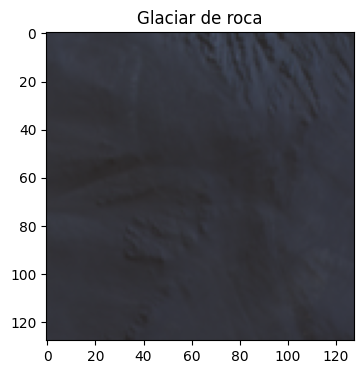

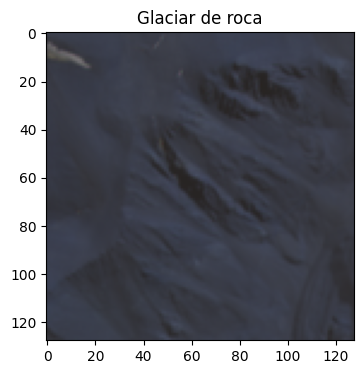

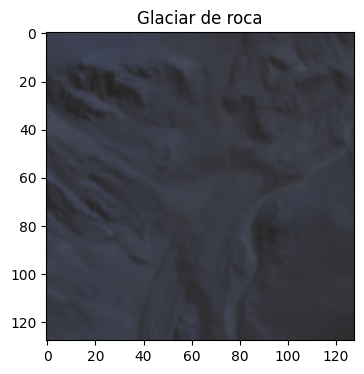

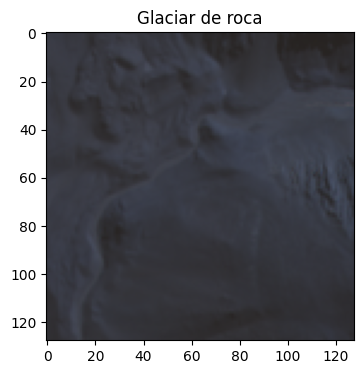

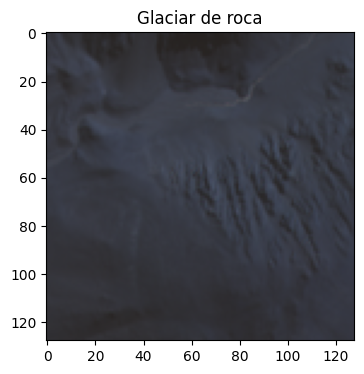

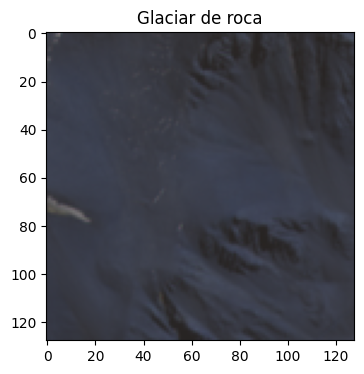

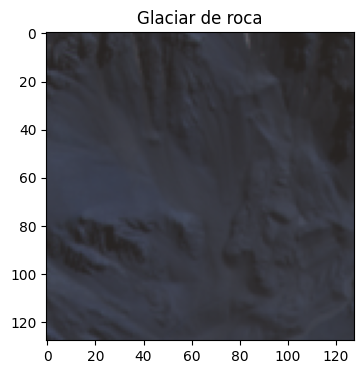

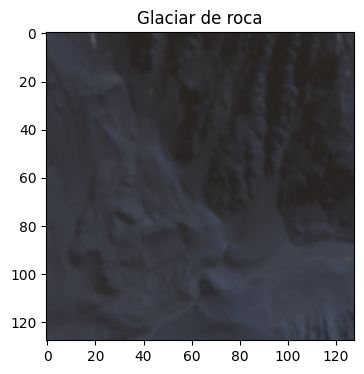

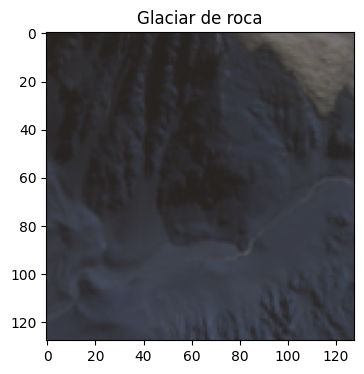

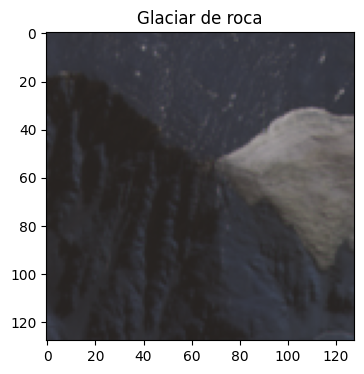

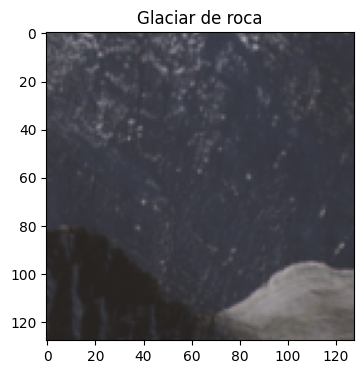

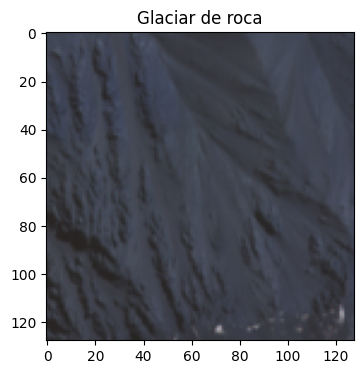

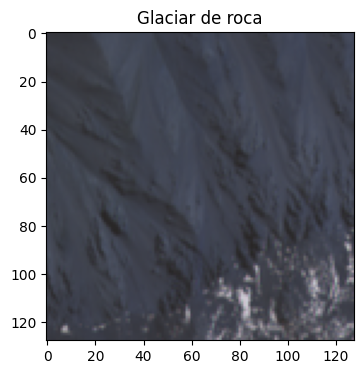

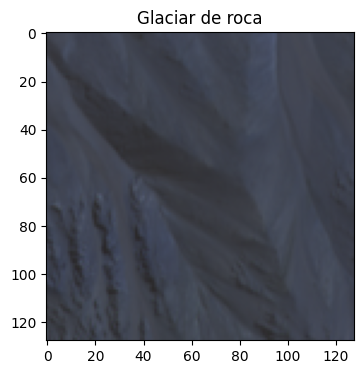

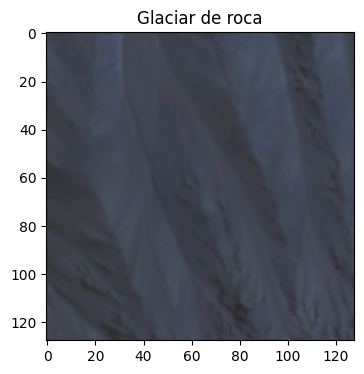

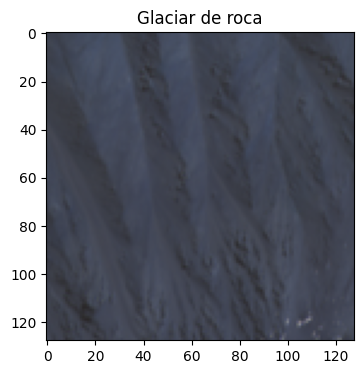

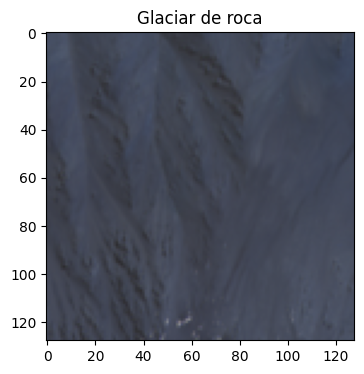

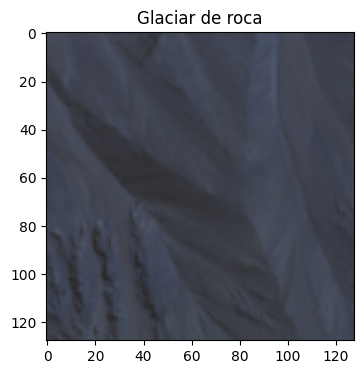

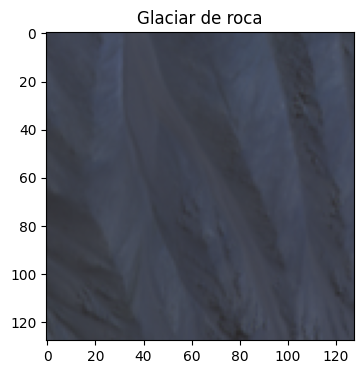

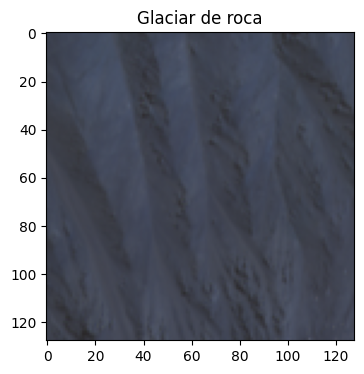

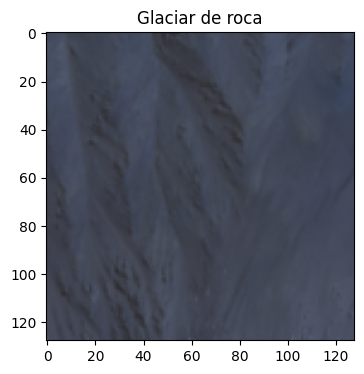

In [14]:
dataset = Sentinel2(path)
# Se testea un una zona donde hay glaciar de roca. Especificamente en la zona Maranceles
sampler = GridGeoSampler(dataset, (128,128), (64,64), BoundingBox(429245, 432308, 6851724, 6858871, 0, 9.223372036854776e+18))#RandomGeoSampler(dataset, size=256, length=10)
dataloader = DataLoader(dataset, sampler=sampler, collate_fn=stack_samples, batch_size=1)

all_bands = ["B02", "B03", "B04", "B08"]
rgb_bands = ["B04", "B03", "B02"]

count = 0

for idx, batch in enumerate(dataloader):
    if idx < 100:
        sample = unbind_samples(batch)[0]
        rgb_indices = []
        for band in rgb_bands:
            rgb_indices.append(all_bands.index(band))

        # Reorder and rescale the image
        image = transform(sample["image"][rgb_indices].permute(0, 1, 2)).to('cuda:0') #.permute(0, 1, 2)
        image = image.unsqueeze(0)

        outputs = model(image)
        value, pred = torch.max(outputs,1)
        if pred: #"Glaciar de roca" if pred else "Cordillera"
            count += 1
            dataset.plot(sample, "Glaciar de roca")
    else:
        break
print(count, idx)